<a href="https://colab.research.google.com/github/vsoos/CloudComputing/blob/main/ex4/4_notebook3_gpu/4_3_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 3 - Movie recommendations based on different user's ratings

In [ ]:
!pip install -q pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 27.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

np.random.seed(123)

In [ ]:
folder_path = '/content/drive/MyDrive/cloudcomputing2023_VincenzinaSoos/ex4/4_notebook3_gpu'
os.chdir(folder_path)

In [ ]:
ratings = pd.read_csv('data/ratings.csv')
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'].astype(float), unit='s')

In [ ]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,100836
mean,326.127564,19435.295718,3.501557,2008-03-19 17:01:27.368469248
min,1.000000,1.000000,0.500000,1996-03-29 18:36:55
25%,177.000000,1199.000000,3.000000,2002-04-18 09:57:46
50%,325.000000,2991.000000,3.500000,2007-08-02 20:31:02
75%,477.000000,8122.000000,4.000000,2015-07-04 07:15:44.500000
max,610.000000,193609.000000,5.000000,2018-09-24 14:27:30
std,182.618491,35530.987199,1.042529,NaN


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [ ]:
movies_df = pd.read_csv("data/movies.csv")

In [ ]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Visualisations

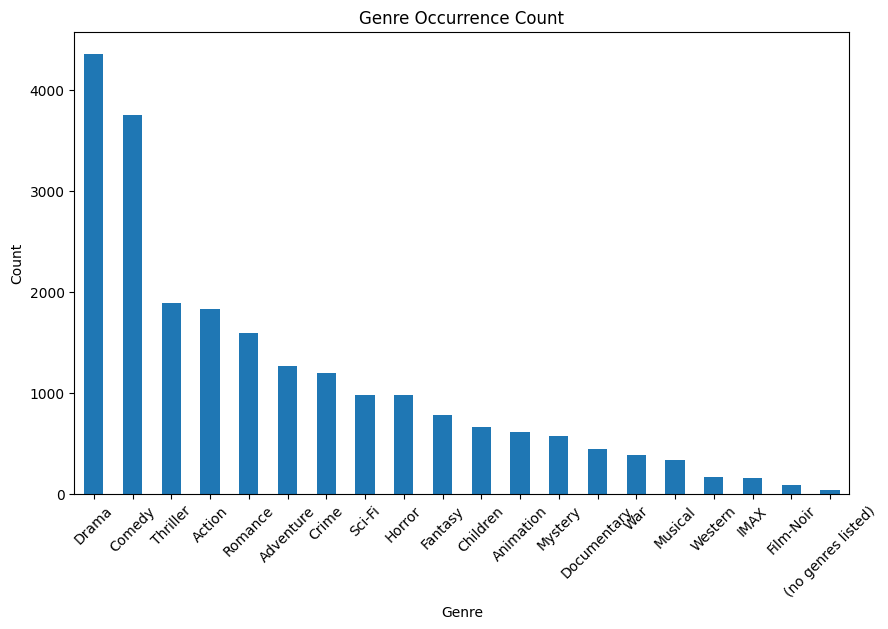

In [ ]:
# Split the genres column and count occurrences
genre_counts = movies_df['genres'].str.split('|').explode().value_counts()

# Plot the counts
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Genre Occurrence Count')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

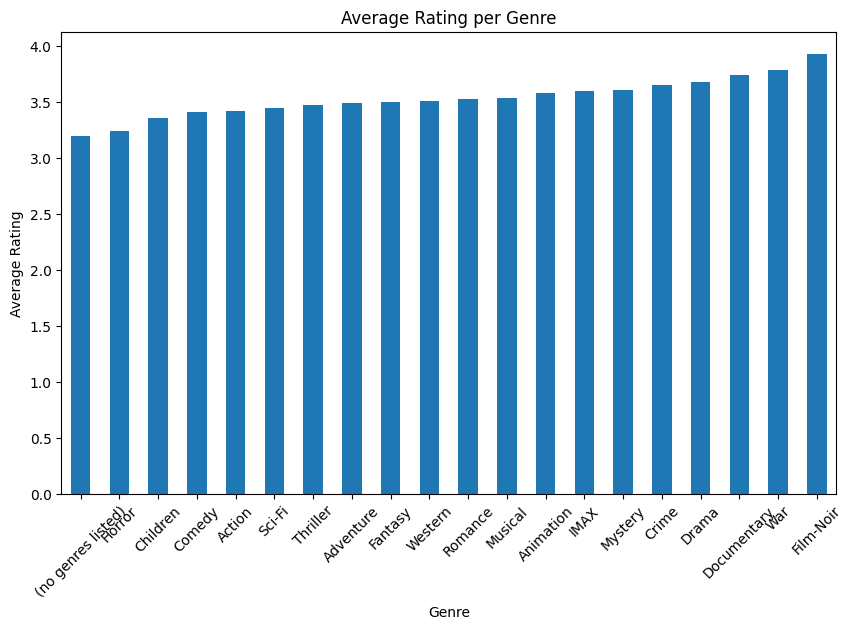

In [ ]:
movies_with_ratings = pd.merge(movies_df, ratings, on='movieId')

# each genre with its rating
genres_ratings = movies_with_ratings[['genres', 'rating']].copy()
genres_ratings = genres_ratings.assign(genres=genres_ratings['genres'].str.split('|')).explode('genres')

# average rating per genre
genre_avg_ratings = genres_ratings.groupby('genres')['rating'].mean()

# Plot the average ratings
plt.figure(figsize=(10, 6))
genre_avg_ratings.sort_values().plot(kind='bar')
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

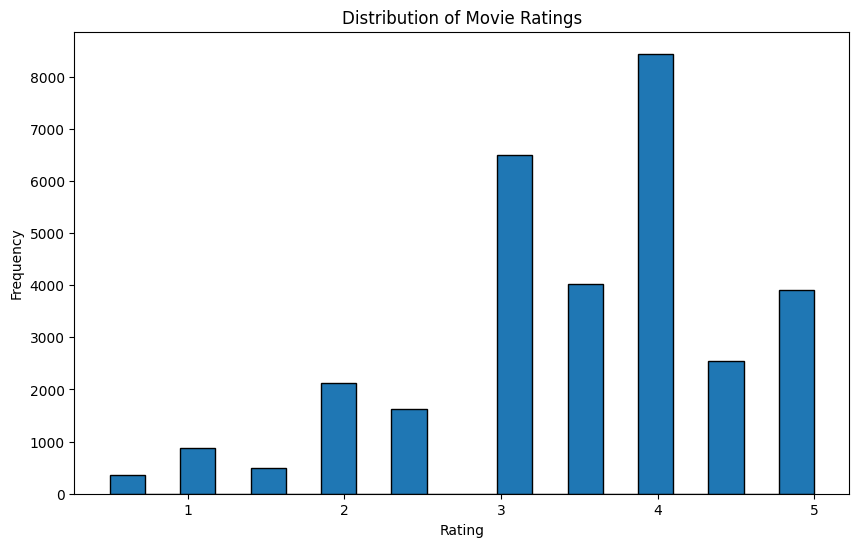

In [ ]:
plt.figure(figsize=(10, 6))
ratings['rating'].plot(kind='hist', bins=20, edgecolor='black')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

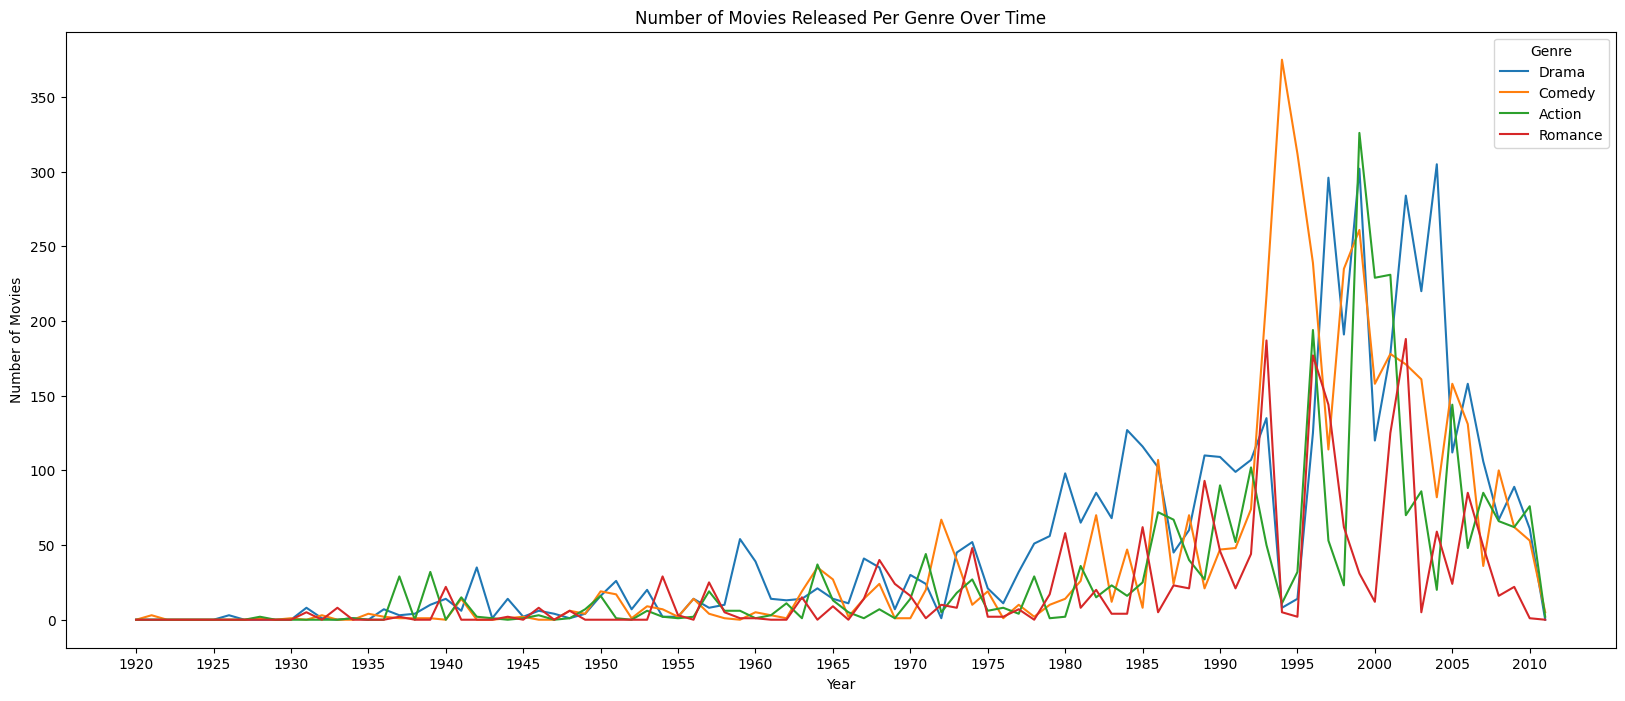

In [ ]:
genres_ratings = genres_ratings.rename(columns={'index': 'movieId'})

#  align years with genres
genre_by_year = genres_ratings.merge(
    movies_with_ratings[['movieId', 'year']],
    on='movieId',
    how='inner'
)

# Group by year and genres
genre_trend = genre_by_year.groupby(['year', 'genres']).size().unstack().fillna(0)

# trend for the most popular genres
plt.figure(figsize=(20, 8))
genre_trend[['Drama', 'Comedy', 'Action', 'Romance']].plot(ax=plt.gca())

plt.title('Number of Movies Released Per Genre Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(np.arange(int(genre_trend.index.min()), int(genre_trend.index.max()) + 1, 5))
plt.legend(title='Genre')
plt.show()

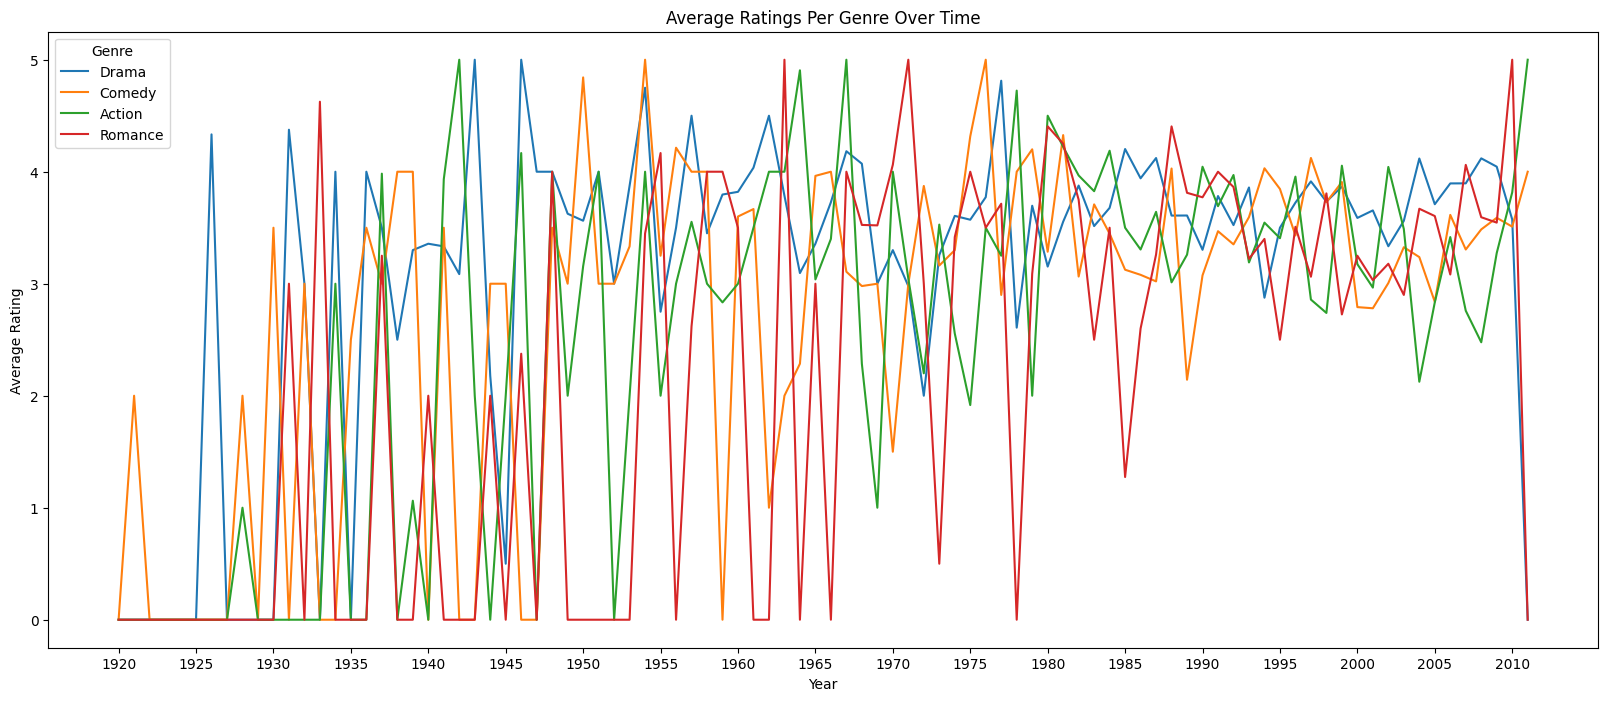

In [ ]:
genre_by_year_rating = genres_ratings.merge(
    movies_with_ratings[['movieId', 'year', 'rating']],
    on='movieId',
    how='inner'
)
genre_by_year_rating = genre_by_year_rating.rename(columns={'rating_x': 'rating'}) \
                                           .groupby(['year', 'genres'])['rating'] \
                                           .mean().unstack().fillna(0)

# Plot the trend
plt.figure(figsize=(20, 8))
genre_by_year_rating[['Drama', 'Comedy', 'Action', 'Romance']].plot(ax=plt.gca())
plt.title('Average Ratings Per Genre Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks(np.arange(int(genre_by_year_rating.index.min()), int(genre_by_year_rating.index.max()) + 1, 5))
plt.legend(title='Genre')
plt.show()


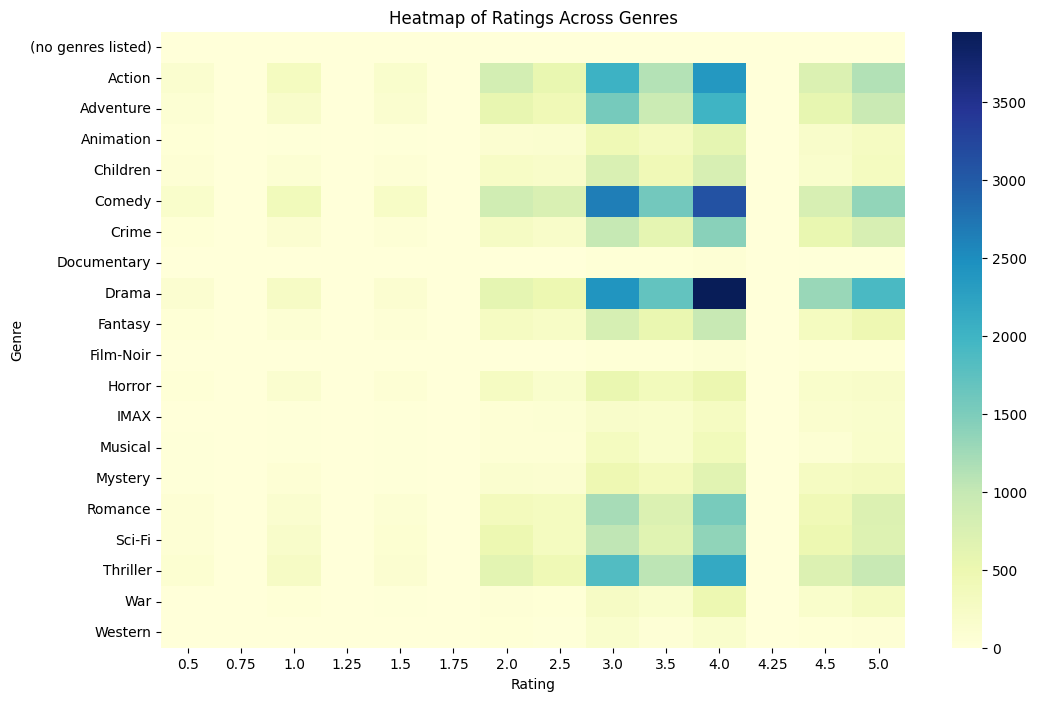

In [ ]:
genre_rating_matrix = genres_ratings.pivot_table(index='genres', columns='rating', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(genre_rating_matrix, cmap='YlGnBu', annot=False)
plt.title('Heatmap of Ratings Across Genres')
plt.xlabel('Rating')
plt.ylabel('Genre')
plt.show()

## Data preparation

In [ ]:
# testing with a search that removes the year
movies_df[movies_df["title"].str.slice(0, -7) == "Beautiful Mind, A"]

,movieId,title,genres
3640,4995,"Beautiful Mind, A (2001)",Drama|Romance


In [ ]:
keyword = "star trek"

# search for titles containing the keyword
matching_movies = movies_df[movies_df['title'].str.contains(keyword, case=False, na=False)]

if not matching_movies.empty:
    pd.set_option('display.max_colwidth', None)
    print(matching_movies[['movieId', 'title']])
else:
    print(f"No movies found with the keyword '{keyword}'.")

      movieId                                          title
287       329                  Star Trek: Generations (1994)
1044     1356                Star Trek: First Contact (1996)
1054     1371           Star Trek: The Motion Picture (1979)
1055     1372  Star Trek VI: The Undiscovered Country (1991)
1056     1373         Star Trek V: The Final Frontier (1989)
1057     1374         Star Trek II: The Wrath of Khan (1982)
1058     1375     Star Trek III: The Search for Spock (1984)
1059     1376           Star Trek IV: The Voyage Home (1986)
1794     2393                 Star Trek: Insurrection (1998)
4132     5944                      Star Trek: Nemesis (2002)
7018    68358                               Star Trek (2009)
8159   102445                 Star Trek Into Darkness (2013)
8917   135569                        Star Trek Beyond (2016)


In [ ]:
# MY MOVIE LIST (Dramas High, Fantasy/Sci-fi Low)
my_movies = {
    "Dead Poets Society": 4.0,
    "Love Actually": 3.5,
    "Shawshank Redemption, The": 5.0,
    "Notebook, The": 4.0,
    "Lovesick": 4.5,
    "Beautiful Mind, A": 4.25,
    "Magdalene Sisters, The": 4.5,
    "Requiem for a Dream": 4.0,
    "Lord of the Rings: The Two Towers, The": 1.0,
    "Lord of the Rings: The Return of the King, The": 1.5,
    "Lord of the Rings, The": 1.25,
    "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone)": 1.5,
    "Harry Potter and the Prisoner of Azkaban": 1.75,
    "Star Trek: The Motion Picture": 0.5,
    "Star Trek IV: The Voyage Home": 0.75,
    "Star Wars: Episode II - Attack of the Clones": 0.5,
    "Stargate": 1.0
}

print(len(my_movies))

17


In [ ]:
userIds_list = [150000] * len(my_movies)

movieIds_list = []
ratings_list = []
dates_list = []

starting_date_timestamp = 1668067820
one_day_duration = 86400

In [ ]:
for movie_name in my_movies:
  # extract the movie's rating and its position in the list
  movie_rating = my_movies[movie_name]
  movie_counter = list(my_movies.keys()).index(movie_name)
  # calculate the date the movie was watched based on its order
  movie_watch_date = starting_date_timestamp - (movie_counter * one_day_duration * 21)

  # handle cases where the movie name doesn't contain a pipe
  if "|" not in movie_name:

    # find the movie ID by matching its title in the dataset
    search_result = movies_df[movies_df["title"].str.slice(0, -7) == movie_name]['movieId']

    # check the search result
    if len(search_result.index) == 1:
      movie_id = search_result.astype(int).item()
      movieIds_list.append(movie_id)
      ratings_list.append(movie_rating)
      dates_list.append(movie_watch_date)

    # A) no matching movie found
    elif len(search_result.index) == 0:
      print("------------------------------")
      print(f"The following movie doesn't exist in the dataset (check exact spelling): {movie_name}")
      print("------------------------------")

    # B) multiple releases with the same name detected
    else:
      # there are multiple releases with the same year
      # the user has to define which year to use
      print("------------------------------")
      print(f"The following movie has multiple release years: {movie_name}")
      print("------------------------------")

  else:
    # handle cases where the movie name contains a pipe
    parts = movie_name.split("|")
    movie_name = parts[0]
    movie_year = parts[1]

    # incl. the year
    movie_name = f"{movie_name} ({movie_year})"

    #find the exact match for the movie name with the year
    search_result = movies_df[movies_df["title"] == movie_name]

    # select the first matching result
    search_result_single = search_result.iloc[0]

    # store the movie's ID, rating, and watch date
    movie_id = search_result_single['movieId'].astype(int).item()
    movieIds_list.append(movie_id)
    ratings_list.append(movie_rating)
    dates_list.append(movie_watch_date)

In [ ]:
print(userIds_list)
print(movieIds_list)
print(ratings_list)
print(dates_list)

[150000, 150000, 150000, 150000, 150000, 150000, 150000, 150000, 150000, 150000, 150000, 150000, 150000, 150000, 150000, 150000, 150000]
[1246, 6942, 318, 8533, 132488, 4995, 6591, 3949, 5952, 7153, 2116, 4896, 8368, 1371, 1376, 5378, 316]
[4.0, 3.5, 5.0, 4.0, 4.5, 4.25, 4.5, 4.0, 1.0, 1.5, 1.25, 1.5, 1.75, 0.5, 0.75, 0.5, 1.0]
[1668067820, 1666253420, 1664439020, 1662624620, 1660810220, 1658995820, 1657181420, 1655367020, 1653552620, 1651738220, 1649923820, 1648109420, 1646295020, 1644480620, 1642666220, 1640851820, 1639037420]


In [ ]:
# randomly select 30% of unique users
# filter the ratings dataset to include only their data
rand_userIds = np.random.choice(ratings['userId'].unique(),
                                size=int(len(ratings['userId'].unique())*0.3),
                                replace=False)

# filter: only include rows from the selected users
ratings = ratings.loc[ratings['userId'].isin(rand_userIds)]

print('There are {} rows of data from {} users'.format(len(ratings), len(rand_userIds)))

There are 30865 rows of data from 183 users


In [ ]:
# rank each user's ratings based on the timestamp in desc order
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

# filter out the 30% user data
ratings = ratings.loc[ratings['userId'].isin(rand_userIds)]

# create a dictionary for adding custom movie data (user-provided movies)
rows_dict = {"userId": userIds_list, "movieId": movieIds_list, "rating": ratings_list, "timestamp": dates_list}
new_rows = pd.DataFrame.from_dict(rows_dict)

In [ ]:
# convert the timestamp column in the new rows to datetime format
new_rows['timestamp'] = pd.to_datetime(new_rows['timestamp'], unit="s")
ratings = pd.concat([ratings, new_rows], ignore_index=True)
print('There are {} rows of data from {} users'.format(len(ratings), len(rand_userIds)))

There are 30882 rows of data from 183 users


In [ ]:
# our userId == 150000
ratings.tail(30)

,userId,movieId,rating,timestamp,rank_latest
30852,608,42738,4.00,2006-05-16 15:47:10,75.0
30853,608,43928,2.00,2006-05-13 13:38:52,80.0
30854,608,44191,4.00,2006-05-18 14:57:56,39.0
30855,608,44665,4.00,2006-05-13 18:13:18,78.0
30856,608,45499,4.00,2007-09-09 23:34:18,31.0
30857,608,49284,3.50,2007-09-11 00:36:49,30.0
30858,608,51255,4.50,2007-09-12 02:24:54,2.0
30859,608,51662,5.00,2007-09-12 02:24:49,3.0
30860,608,51903,2.50,2007-09-11 02:28:56,5.0
30861,608,51935,4.00,2007-09-12 02:24:46,4.0


In [ ]:
# check if 'timestamp' column is in datetime format
if not pd.api.types.is_datetime64_any_dtype(ratings['timestamp']):
     # convert 'timestamp' to datetime
    numeric_mask = pd.to_numeric(ratings['timestamp'], errors='coerce').notna()
    ratings.loc[numeric_mask, 'timestamp'] = pd.to_datetime(ratings.loc[numeric_mask, 'timestamp'], unit='s', errors='raise')
else:
    print("Timestamp column is already in datetime format. Skipping conversion.")

# Rank ratings for users based on the timestamp in desc order
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

# drop columns that we no longer need
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

Timestamp column is already in datetime format. Skipping conversion.


In [ ]:
train_ratings.loc[:, 'rating'] = 1
train_ratings.sample(5)

,userId,movieId,rating
10521,274,908,1.0
18505,387,5959,1.0
20564,477,1103,1.0
6549,186,2492,1.0
14982,339,89492,1.0


In [ ]:
# list of all unique movie IDs
all_movieIds = ratings['movieId'].unique()

# placeholders to store training data
users, items, labels = [], [], []

# create a set of user-item interactions from the training dataset
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

# ratio - negative:positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive

    # Generate negative samples for the same user
    for _ in range(num_negatives):
        # randomly select a movie
        negative_item = np.random.choice(all_movieIds)
        # check that the user has not interacted with this movie
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        # Add negative sample
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

  0%|          | 0/30698 [00:00<?, ?it/s]

In [ ]:
class MovieLensTrainDataset(Dataset):
    """MovieLens PyTorch Dataset for Training

    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds

    """
    # Generate the dataset with users, items, and labels
    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        # total number of samples
        return len(self.users)

    def __getitem__(self, idx):
      # Retrieve a single sample at the given index
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        # placeholders for users, items, and labels
        users, items, labels = [], [], []

        # user-movie interactions for lookup
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        # Generate negative samples for the user
        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        # lists to PyTorch tensors
        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

## Our model - Neural Collaborative Filtering (NCF)

In [ ]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)

        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """

    # MODEL
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds

    def forward(self, user_input, item_input):

        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred

    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds),
                          batch_size=512, num_workers=4)

In [ ]:
num_users = ratings['userId'].max()+1 # total number of users
num_items = ratings['movieId'].max()+1 # total number of movies

all_movieIds = ratings['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

In [ ]:
trainer = pl.Trainer(max_epochs=15,
                     accelerator='gpu',
                     logger=False,
                     enable_checkpointing = True,
                     devices=1,
                     enable_progress_bar = True,
                     log_every_n_steps = 50)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/cloudcomputing2023_VincenzinaSoos/ex4/4_notebook3_gpu/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params | Mode 
-----------------------------------------------------
0 | user_embedding | Embedding | 1.2 M  | train
1 | item_embedding | Embedding | 1.5 M  | train
2 | fc1            | Linear    | 1.1 K  | train
3 | fc2            | Linear    | 2.1 K  | train
4 | output         | Linear    | 33     | train
-----------------------------------------------------


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


## Evaluating our Recommender System

In [ ]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

# items each user interacted with, stored in a dictionary
user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()

# list to save recommendations for user 150000
our_result = []

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)

    # randomly select 99 negative samples
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    # combine negative samples with the positive sample
    test_items = selected_not_interacted + [i]

    predicted_labels = np.squeeze(model(torch.tensor([u]*100),
                                        torch.tensor(test_items)).detach().numpy())

    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

    # save recommendations for user 150000
    if u == 150000:
      # check if the positive item is in the top 10
      our_results = top10_items

    if i in top10_items:
        hits.append(1) # hit
    else:
        hits.append(0) # miss

print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

  0%|          | 0/184 [00:00<?, ?it/s]

The Hit Ratio @ 10 is 0.48


In [ ]:
# check that we have some movie ids inside the list
our_results

[6539, 3793, 150, 4226, 736, 7361, 1246, 1250, 80463, 3868]

In [ ]:
amount = len(our_results)
print("Top 10 Recommendations")
# go through our top 10 recommendations from the algorithm
for x in range(amount):
  item = our_results[x]
  # get the movie title for the recommended movie ID
  movie_name = movies_df[movies_df['movieId'] == item]['title'].item()
  # print the rank and title
  print(f"{x + 1}. {movie_name}")

Top 10 Recommendations
1. Pirates of the Caribbean: The Curse of the Black Pearl (2003)
2. X-Men (2000)
3. Apollo 13 (1995)
4. Memento (2000)
5. Twister (1996)
6. Eternal Sunshine of the Spotless Mind (2004)
7. Dead Poets Society (1989)
8. Bridge on the River Kwai, The (1957)
9. Social Network, The (2010)
10. Naked Gun: From the Files of Police Squad!, The (1988)
